## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 3

A testbed for making Fig.3 :  the 4 x 4 histogram plot. It shows that   0   < log(tau) < 1.7 (short timescales bin), does not exhibit any variability, because chi_ij for qso and stars is almost undistinguishable for uncorrected points. 



** What happens here : **

We run the cells below for different magnitude  cuts (changing Min and  Max  parameters below) :  17-18 ,  18-18.5 ,  18.5-19.  

Each run reads in xi, ei points for quasars  , blue stars.  We read in xi (mi  : magnitude  difference) , tau (time difference),   ei (magnitude difference error)  points separately for 4 timescale bins in log(delta t)  space . 

A list of xi, tau,  ei  per magnitude per timescale per object type (quasar or a star) is saved as a .txt file in the folder structure data_products/Fig_3_data/year-month-day/r_cut_Min-Max_object_mi_tau_ei_log_tau_min_max.txt 


Then we read in each xi,tau,ei file,  and  for every point in a given  magnitude-timescale-object bin we calculate  chi quantity.   Thus we make a histogram of chi values for magnitude-timescale-object grid, resulting in  a  4 x 3 x 2  histograms .  The robust width of the chi distribution for each bin is a signature of intrinsic variability. 


In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import CRTS_paper_modules as mod
import datetime


In [3]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()


Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


## Read in points  m_ij , e_ij , tau  from master files 

In [4]:
star_cat

{'CRTS_M': array([ 20.04798,  15.95652,  17.47582, ...,  19.74864,  17.12618,  20.002  ]),
 'CRTS_Merr': array([ 0.18944,  0.03524,  0.05099, ...,  0.13395,  0.04733,  0.2385 ]),
 'N_rows': array([  23.,   90.,   99., ...,  114.,   94.,   72.]),
 'crts_id': array([ 392106.,  315542.,  700105., ...,  964473.,  864141.,  744009.]),
 'dec_CRTS': array([-0.79702,  0.4    , -0.50307, ..., -1.20402, -1.18179, -0.42934]),
 'dec_SDSS': array([-0.79702,  0.4    , -0.50307, ..., -1.20402, -1.18179, -0.42934]),
 'g_Nobs': array([  4.,  13.,   9., ...,  10.,   9.,  11.]),
 'g_mMed': array([ 22.49 ,  16.886,  18.101, ...,  21.743,  17.757,  22.042]),
 'i_mMed': array([ 19.927,  15.848,  17.205, ...,  19.194,  17.07 ,  19.419]),
 'm_ang_deg': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'mjd_N': array([  23.,   90.,   99., ...,  114.,   94.,   72.]),
 'mjd_span': array([ 3041.,  2920.,  3070., ...,  2997.,  3055.,  3042.]),
 'r_mMed': array([ 21.068,  16.174,  17.473, ...,  20.351,  17.242,  20.634]

In [25]:
Min = 18
Max = 18.5
magnitudes = ['r']  # don't need g magnitude , decided to use only r magnitude 

# Where to save the samples of log(tau), as well as the table results  ... 

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_3_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_3 files in %s'%outDir)

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
   
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))


    good_ids_S_blue = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,  gi_Max=1, cut_mag=cut_mag + '_mMed')
    
    #good_ids_S_red = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
    #                                       gi_Max=3, cut_mag=cut_mag + '_mMed')
    
    good_ids_QSO = mod.cut_qso(qso_cat = qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'qso':good_ids_QSO}
    

Today we will save our Fig_3 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_3_data/2017-01-10/

Using now only lightcurves with SDSS  18.000000< r < 18.500000

 These cuts reduced the number of stars  in the sample from 48250 to 1400
Returning only QSO which had an SDSS counterpart within 0.000278 radians

 These cuts reduced the number of qso  in the sample from 7601 to 333


## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

In [26]:
bins = {}
bin_types = ['r_cut']  # removed 'g_cut'

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]


## Read the xi, ei for objects in the r_cut ... 

In [27]:
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print('Reading in xi, ei for bin %s'%b )
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
#good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB = mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO, good_ids_QSO)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin r_cut
making new delflx, tau, xi arrays


Reading in quasars...
Returning delta_time in observed frame, t_obs
[######### ] 99.10%

Reading in blue stars ...
[##########] 100.00%

Reading in red stars ...


## Save to a file all points for samples of log(tau) for a given mag cut, only for qso and starsB 

In [28]:
print('Saving xi,tau,ei points for this magnitude bin to: \n %s'%outDir)

Saving xi,tau,ei points for this magnitude bin to: 
 /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_3_data/2017-01-10/


In [29]:
## Save to a file points for log(tau) samples  for QSO, stars 

b = 'r_cut'   # or g_cut

tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
for obj in ['qso','starsB']:
    #obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij =  out_dic[b][obj][2]
    
    for i in range(len(tau_min_arr)):
        m1 = tau_min_arr[i] < np.log10(tau)
        m2 = np.log10(tau) < tau_max_arr[i]
        mask =  m1 * m2 

        data = np.column_stack((m_ij[mask], tau[mask], e_ij[mask]))
       
        fname = b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_mi_tau_ei-log_tau_'+\
                str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        print('Saved %s' % fname)
        np.savetxt(outDir+fname, data, fmt='%s', delimiter= ' ')


Saved r_cut_18-18.5_qso_mi_tau_ei-log_tau_0-1.7.txt
Saved r_cut_18-18.5_qso_mi_tau_ei-log_tau_2.3-2.5.txt
Saved r_cut_18-18.5_qso_mi_tau_ei-log_tau_2.8-3.0.txt
Saved r_cut_18-18.5_qso_mi_tau_ei-log_tau_3.2-3.4.txt
Saved r_cut_18-18.5_starsB_mi_tau_ei-log_tau_0-1.7.txt
Saved r_cut_18-18.5_starsB_mi_tau_ei-log_tau_2.3-2.5.txt
Saved r_cut_18-18.5_starsB_mi_tau_ei-log_tau_2.8-3.0.txt
Saved r_cut_18-18.5_starsB_mi_tau_ei-log_tau_3.2-3.4.txt


--> Now go up, and change Min, Max to the next magnitude bin, until all options have been exhausted 

## Plotting the histogram grid for qso and starsB 

Define function used to plot each histogram in the grid ... 

In [30]:
b = 'r_cut'
# Use today's data... 
# --> do not change the outDir 

# Use data from another day : 
#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data/2016-06-07/')

def plot2Chistograms(chiQSO, chiSTAR, Xmin, Xmax, Ymin, Ymax, Xlabel, Ylabel, ax, bins=20, title=''):
    limits = [(Xmin, Xmax, Ymin, Ymax)]
    labels = [Xlabel, Ylabel]
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    #ax.set_xlabel(Xlabel, fontsize=12)
    #ax.set_ylabel(Ylabel, fontsize=12)
     # http://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
        
        
    #plt.tick_params(axis='both', which='major', labelsize=15)
    xTitle = Xmin + 0.05*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    ax.text(xTitle, yTitle, title, fontsize=12)

    # plot a histogram
    ax.hist(chiSTAR, bins=bins, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.4)
    ax.hist(chiQSO, bins=bins, normed=True, facecolor='red', histtype='stepfilled', alpha=0.2)

    # plot the robust width of both distributions
    stdev_rob_QSO = 0.7414 *(np.percentile(chiQSO,75) - np.percentile(chiQSO,25) )
    stdev_rob_S = 0.7414 *(np.percentile(chiSTAR,75) - np.percentile(chiSTAR,25) )
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    StarSigmaG = r'$'+str(stdev_rob_S)[:4]+'$'
    ax.text(xTitle, yTitle, StarSigmaG, fontsize=12)
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.35*(Ymax-Ymin)
    QSOSigmaG = r'$'+str(stdev_rob_QSO)[:4]+'$'
    ax.text(xTitle, yTitle, QSOSigmaG, fontsize=12)
    
    
Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]
tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
xlims_arr = [5,10,10,10]




Plot the uncorrected histograms 

In [40]:
# plot the same timescale-magnitude range before we get too specific... 
# if with one bin range it looks good, set testing = False, and run for all ... 

testing = False

if testing is True : 
    # just for testing  - load only 1/16 files (one for QSO one for Stars) and experiment with how it looks 
    # if you use that, make sure to comment out those lines below !  
    j=0
    i=0

    datafileS = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                            str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
    vS = np.loadtxt(datafileS, unpack=True)

    datafileQ = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
            str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
    vQ = np.loadtxt(datafileQ, unpack=True)
    print('Read in the xi,tau,ei  data from \n %s and \n %s for testing...'%(datafileS, datafileQ))

saving plot to: /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_3_data/2017-01-10/Fig_3_histogram_panels.png


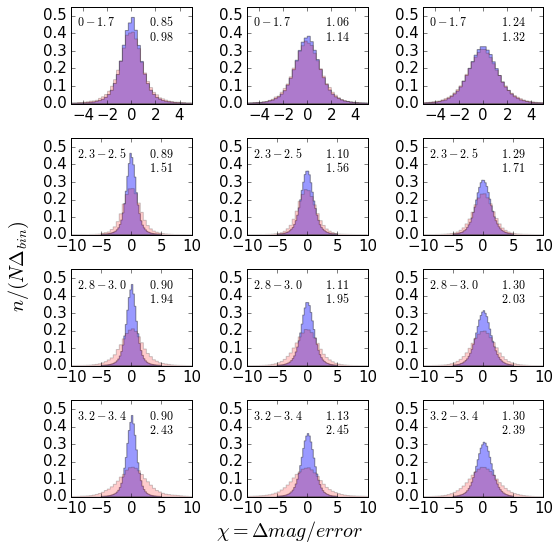

In [41]:
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

%matplotlib inline

fig, axs = plt.subplots(4,3, figsize=(8, 8))
fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.10, top=0.95)

# initiate a storage array for the robust widths of chi distributions ... 
store_fc_starB = np.zeros((3,4))

for i in range(len(tau_max_arr)):  # 
    for j in range(len(Min_arr) ):  # 
        
        #a = coeffs['a'][coeffs['rMagMin'] == Min_arr[j]]
        #b = coeffs['b'][coeffs['rMagMin'] == Min_arr[j]]
        #tau = (tau_max_arr[i] + tau_min_arr[i])/2.0
        #bin_fc = 1.0/ ( a* tau + b)
    
        if testing is not True: 
            datafileS = outDir+'r_cut_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
            vS = np.loadtxt(datafileS, unpack=True)
        
            datafileQ = outDir+'r_cut_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
            vQ = np.loadtxt(datafileQ, unpack=True)
        
        # calculate the robust width of the chi distribution .... 
        #chiS = vS[0]/(bin_fc*vS[2]) # applying the error correction : ei_corr = fc * ei 
        chiS = vS[0] / vS[2]
        chiSok = chiS[np.abs(chiS)<5]
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        
        #chiQ = vQ[0]/(bin_fc*vQ[2]) # applying the correction  
        chiQ = vQ[0]/vQ[2]
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[i]]

        # plot histograms
        Xlabel = '$\chi = \Delta mag / error$'
        Ylabel = '$n / (N\Delta_{bin})$'
        Xmin = -xlims_arr[i]
        Xmax = xlims_arr[i]
        bins = 40 
        title= r'$ '+' '+ str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'$'
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, Xlabel=Xlabel, Ylabel=Ylabel, ax=axs[i,j],bins=bins,  
                         title=title)
        # save the value of robust width of stellar chi distribution...
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        #store_fc_starB[row,column] = [magnitude_max, deltaTrange]
        store_fc_starB[j,i] = stdev_rob_S
fig.text(0.5, 0.04, Xlabel, ha='center', va='center',fontsize=20)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical',fontsize=20)

#name = 'poster_r_cut_qso_starsB_histogram_grid.png'
#name = None
name = outDir+'Fig_3_histogram_panels.png'
if (name is None):
    plt.show() 
else:
    print('saving plot to: %s'%name)
    plt.savefig(name, bbox_inches='tight')
    

Save the robust width of chi distritbution for stars and quasars ... 


In [49]:
data = np.column_stack((store_fc_starB[0], store_fc_starB[1], store_fc_starB[2]))

fname = b+'_starsB_chi_robust_width.txt'
print('Saved %s' % fname)
np.savetxt(outDir+fname, data, fmt='%s', delimiter= ' ')

Saved r_cut_starsB_chi_robust_width.txt


Read-in the robust widths, calculate their mean to use as a correction factor... 

In [53]:
file = outDir + fname
sigmaG_chi_blue_stars = np.loadtxt(file, unpack=True)

Calculate the mean, and save as a correction-factor file : 

In [61]:
fc = np.mean(sigmaG_chi_blue_stars, axis = 1)
fc

array([ 0.88971443,  1.10721   ,  1.2876506 ])

In [62]:
data  = np.column_stack((Min_arr, Max_arr, fc))
fname = b+'_minMag_maxMag_mean_fc.txt'
print('Saved %s' % fname)
np.savetxt(outDir+fname, data, fmt='%s', delimiter= ' ')

Saved r_cut_minMag_maxMag_mean_fc.txt


Plot the corrected histograms, to show that it works ... 

In [71]:
# plot the same timescale-magnitude range before we get too specific... 
# if with one bin range it looks good, set testing = False, and run for all ... 
b = 'r_cut'
testing = False

if testing is True : 
    # just for testing  - load only 1/16 files (one for QSO one for Stars) and experiment with how it looks 
    # if you use that, make sure to comment out those lines below !  
    j=0
    i=0

    datafileS = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                            str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
    vS = np.loadtxt(datafileS, unpack=True)

    datafileQ = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
            str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
    vQ = np.loadtxt(datafileQ, unpack=True)
    print('Read in the xi,tau,ei  data from \n %s and \n %s for testing...'%(datafileS, datafileQ))

saving plot to: /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_3_data/2017-01-10/Fig_3_histogram_panels_corrected.png


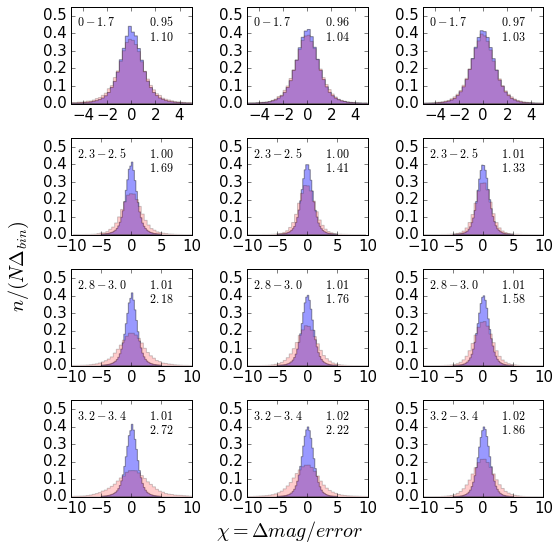

In [73]:
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

%matplotlib inline

fig, axs = plt.subplots(4,3, figsize=(8, 8))
fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.10, top=0.95)

# initiate a storage array for the robust widths of chi distributions ... 
store_fc_starB = np.zeros((3,4))

for i in range(len(tau_max_arr)):  # 
    
    for j in range(len(Min_arr) ):  # 
        
        bin_fc = fc[j]
       
        if testing is not True: 
            datafileS = outDir+'r_cut_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
            vS = np.loadtxt(datafileS, unpack=True)
        
            datafileQ = outDir+'r_cut_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
            vQ = np.loadtxt(datafileQ, unpack=True)
        
        # calculate the robust width of the chi distribution .... 
        chiS = vS[0]/(bin_fc*vS[2]) # applying the error correction : ei_corr = fc * ei 
        chiSok = chiS[np.abs(chiS)<5]
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        
        chiQ = vQ[0]/(bin_fc*vQ[2]) # applying the correction  
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[i]]

        # plot histograms
        Xlabel = '$\chi = \Delta mag / error$'
        Ylabel = '$n / (N\Delta_{bin})$'
        Xmin = -xlims_arr[i]
        Xmax = xlims_arr[i]
        bins = 40 
        title= r'$ '+' '+ str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'$'
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, Xlabel=Xlabel, Ylabel=Ylabel, ax=axs[i,j],bins=bins,  
                         title=title)
        # save the value of robust width of stellar chi distribution...
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        #store_fc_starB[row,column] = [magnitude_max, deltaTrange]
        store_fc_starB[j,i] = stdev_rob_S
fig.text(0.5, 0.04, Xlabel, ha='center', va='center',fontsize=20)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical',fontsize=20)

name = outDir+'Fig_3_histogram_panels_corrected.png'
if (name is None):
    plt.show() 
else:
    print('saving plot to: %s'%name)
    plt.savefig(name, bbox_inches='tight')
    

## [Illustration only ] Calculating the full linear fit along timescales ... 

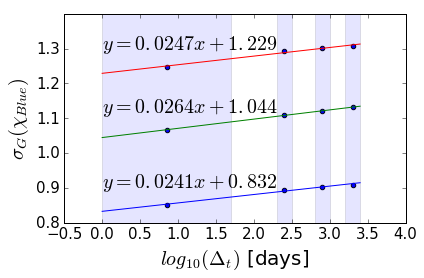

In [63]:
def func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
# popt is func(x, popt*)

fig,ax = plt.subplots()

aCoeffArr = np.zeros(len(Min_arr))
bCoeffArr =np.zeros(len(Min_arr))
stdArr = np.zeros(len(Min_arr))
colors = ['']
for i in range(len(Min_arr)):
    tau_cen = (np.array(tau_max_arr) + np.array(tau_min_arr)) / 2.0
    popt, pcov = curve_fit(func, tau_cen, store_fc_starB[i,:])
    a,b = popt[0], popt[1]
    aCoeffArr[i] = a
    bCoeffArr[i] = b
    
    x = np.sort(np.append(np.array(tau_min_arr), tau_max_arr)) #np.linspace(tau_min_arr[0], tau_min_arr[-1])
    y = a * x + b
    std = np.std(a * np.array(tau_cen)  - store_fc_starB[i,:] )
    stdArr[i] = std
    ax.plot(x,y)
    ax.scatter(tau_cen, store_fc_starB[i,:])
    ax.text(x=0, y=store_fc_starB[i,0]+0.05,  s=r'$y='+str(a)[:6]+'x + '+str(b)[:5]+'$ ', fontsize=20)

for j in range(len(tau_min_arr)):
    ax.fill_between(x=[tau_min_arr[j],tau_max_arr[j]],y1=[0.8,0.8],y2=[1.4,1.4],alpha=0.1)

ax.set_ylim(0.8,1.4)
ax.set_xlabel(r'$log_{10} (\Delta _{t})$ [days]',fontsize=20)
ax.set_ylabel(r'$\sigma_{G}(\chi_{Blue})$',fontsize=20)
plt.tight_layout()
plt.savefig(outDir + 'Blue_Stars_coefficients.png')

In [137]:
# Store the linear correction coefficients 
data = np.column_stack((aCoeffArr, bCoeffArr, stdArr, Min_arr, Max_arr))
np.savetxt(outDir+'fc_starsB_a_b_coeff.txt',data, header='  a      b     stddev   rMagMin  rMagMax',fmt='%2.5f    %2.5f    %2.5f  %2.2f  %2.2f  ')
